# Plug-and-Play Reconstruction with a Pretrained Denoising Network

This example shows how to apply a pretrained denoising network to perform plug-and-play reconstruction.

This exploits the idea that a simple Gaussian denoiser can be extrapolated to other applications, such as CT reconstruction.

In [1]:
%load_ext autoreload
%autoreload 2

## Import libraries

In [2]:
# Standard imports
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from tqdm import tqdm

# Pytorch imports
import torch

# DeepInv imports (for the pretrained denoiser)
import deepinv

# LION imports
from LION.classical_algorithms import fdk
from LION.experiments import ct_experiments
from LION.reconstructors import PnP

## Setup device

In [3]:
# % Chose device:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

## Load the dataset

In [4]:
experiment = ct_experiments.LowDoseCTRecon(dataset="LIDC-IDRI")
lidc_testing_dataset = torch.utils.data.Subset(experiment.get_testing_dataset(), range(3))  # Use only 3 images for the demo

Preparing patient list, this may take time....
Patient lists ready for test dataset


## Estimate the noise level

For the end-to-end denoising, we need to provide the model with a noise estimation. We estimate the noise level with one sample.

In [5]:
# Estimate the noise level from one sample of the dataset
sino, target = lidc_testing_dataset[0]

recon = fdk(sino, op=experiment.geometry)
diff = recon - target
est_noise_std = diff.std().item()
print(f"Estimated noise std: {est_noise_std:.4f}")

Estimated noise std: 0.4146


## Load the pretrained denoising network

In [6]:
# Get pretrained DRUNet denoiser
denoiser = deepinv.models.DRUNet(pretrained="download", device=device)

## Helper metric function

In [7]:
def ssim_torch(target: torch.Tensor, input: torch.Tensor) -> float:
    """Adapt SSIM function for torch tensors."""
    target = target.cpu().numpy().squeeze()
    input = input.cpu().numpy().squeeze()
    return structural_similarity(target, input, data_range=target.max() - target.min())

## Define the Plug-and-Play reconstructor

Note that in this example,
we use a different noise level estimation for the plug-and-play reconstruction.
For the plug-and-play reconstruction, we use a much smaller value compared to the estimated value from the one sample.

In [8]:
def denoiser_fn(ct_image: torch.Tensor, sigma: float = None) -> torch.Tensor:
    with torch.no_grad():
        if sigma is None:
            sigma = est_noise_std
        ct_image = ct_image.repeat(1, 3, 1, 1)  # grayscale 2D to 4-channel batch
        denoised = denoiser(ct_image, sigma=sigma)
        denoised = torch.mean(denoised, dim=1)  # average the channels to get grayscale
    return denoised


def denoiser_fn_admm(ct_image: torch.Tensor) -> torch.Tensor:
    # Denoiser's input sigma used in PnP is much lower than the estimated value.
    return denoiser_fn(ct_image, sigma=0.06)


reconstructor = PnP(
    experiment.geometry, model=denoiser_fn_admm, algorithm="ADMM"
)

## Perform Plug-and-Play reconstruction

Testing samples: 100%|██████████| 3/3 [00:09<00:00,  3.27s/it]


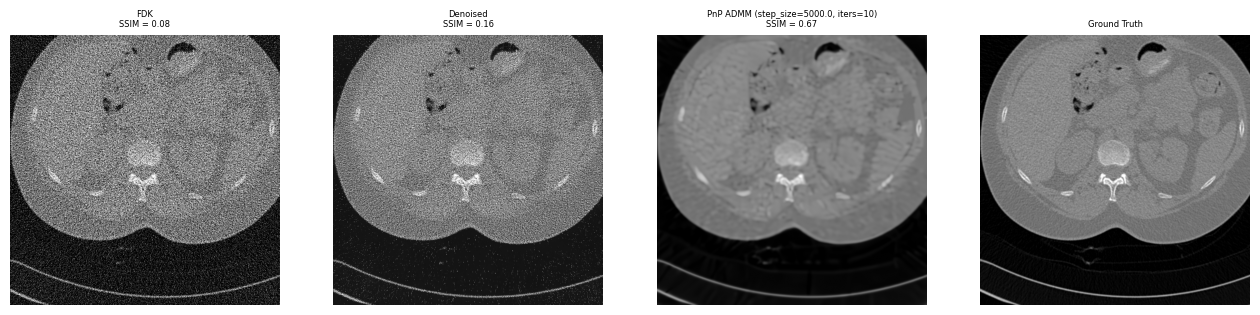

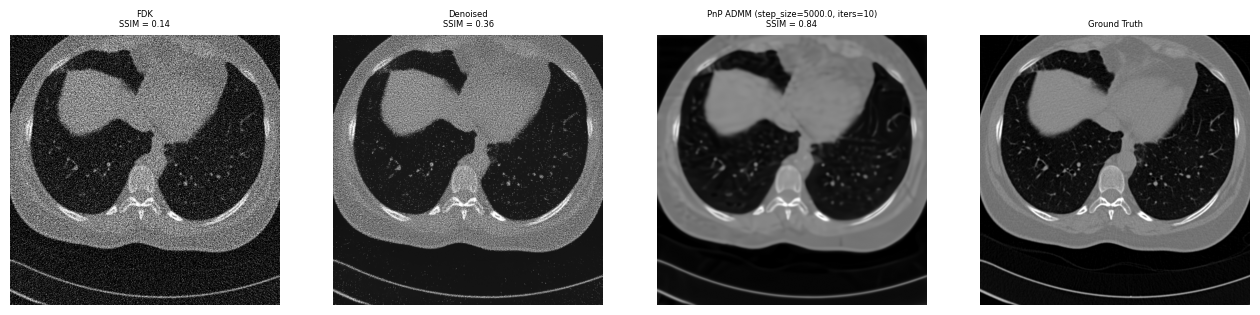

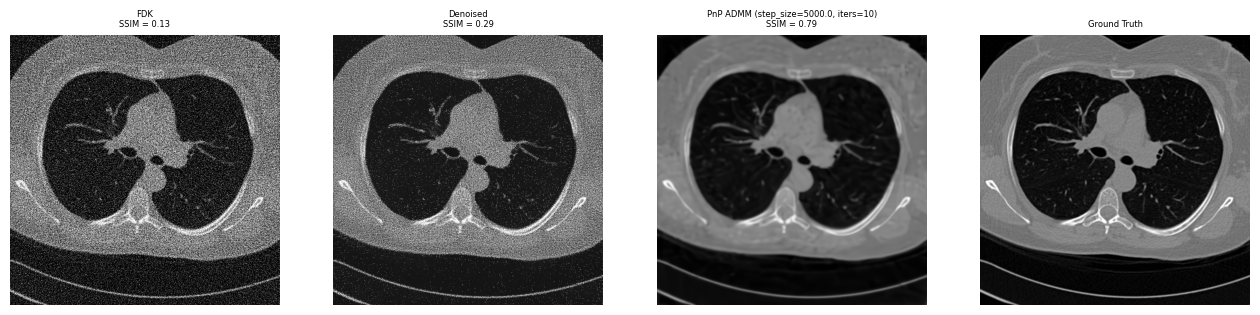

In [10]:
admm_iterations = 10
admm_step_size = 5e3
cg_max_iter = 100
cg_tol = 1e-7

for i, (sino, target) in tqdm(enumerate(lidc_testing_dataset), total=len(lidc_testing_dataset), desc="Testing samples"):
    sino: torch.Tensor = sino.unsqueeze(0)  # Add batch dimension
    target: torch.Tensor = target.unsqueeze(0)  # Add batch dimension

    sino = sino.to(device)
    target = target.to(device)
    recon = fdk(sino, op=experiment.geometry)

    denoised = denoiser_fn(recon.clone()).unsqueeze(0)

    # PnP reconstruction
    pnp_admm_result = reconstructor.reconstruct_sample(
        sino.squeeze(0),
        eta=admm_step_size,
        max_iter=admm_iterations,
        cg_max_iter=cg_max_iter,
        cg_tol=cg_tol,
        prog_bar=True,
    ).unsqueeze(0)

    n_subplots = 4
    plt.figure(figsize=(n_subplots * 4, 4))

    plt.subplot(1, n_subplots, 1)
    plt.imshow(recon[0, 0].cpu(), cmap="gray")
    plt.clim(0, 2)
    plt.axis("off")
    plt.title(
        "FDK" + "\nSSIM = {:.2f}".format(ssim_torch(target[0], recon[0])), fontsize=6
    )

    plt.subplot(1, n_subplots, 2)
    plt.imshow(denoised[0, 0].cpu(), cmap="gray")
    plt.clim(0, 2)
    plt.axis("off")
    plt.title(
        "Denoised" + "\nSSIM = {:.2f}".format(ssim_torch(target[0], denoised[0])),
        fontsize=6,
    )

    plt.subplot(1, n_subplots, 3)
    plt.imshow(pnp_admm_result[0, 0].cpu(), cmap="gray")
    plt.title(
        f"PnP ADMM (step_size={admm_step_size}, iters={admm_iterations})"
        + "\nSSIM = {:.2f}".format(ssim_torch(target[0], pnp_admm_result[0])),
        fontsize=6,
    )
    plt.clim(0, 2)
    plt.axis("off")

    plt.subplot(1, n_subplots, n_subplots)
    plt.imshow(target[0, 0].cpu(), cmap="gray")
    plt.title("Ground Truth", fontsize=6)
    plt.axis("off")
    plt.clim(0, 2)

    plt.savefig(
        f"test_{i}-admm_stepsize{admm_step_size:.0e}_iters{admm_iterations}.png",
        bbox_inches="tight",
        dpi=300,
    )

As mentioned previously, we use a smaller noise estimation parameter for the plug-and-play algorithm (compared to the estimated value). This was seen to improve the reconstruction quality. A much higher value would oversmooth the image. 

That's it! We have successfully run a PnP reconstruction with a pretrained DRUNet as denoiser prior.